In [2]:
cd '/content/drive/MyDrive/Thesis/Code'

/content/drive/MyDrive/Thesis/Code


In [ ]:
cd '/content/drive/MyDrive/Thesis/Code/crfrnn_layer'

/content/drive/MyDrive/Thesis/Code/crfrnn_layer


In [ ]:
!python setup.py install

In [ ]:
!pip install pytorch-lightning
!pip install segmentation-models-pytorch
!pip install crfseg
!pip install kornia

     |████████████████████████████████| 839kB 10.7MB/s 
     |████████████████████████████████| 276kB 23.0MB/s 
     |████████████████████████████████| 112kB 37.1MB/s 
     |████████████████████████████████| 829kB 35.2MB/s 
     |████████████████████████████████| 184kB 37.6MB/s 
     |████████████████████████████████| 1.3MB 42.2MB/s 
     |████████████████████████████████| 296kB 42.3MB/s 
     |████████████████████████████████| 143kB 46.9MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=90f1f4e1b0a5330c01283efca033878bfd5fbf79bd415ea385dc608a0dae7300
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=e71790eafaecd2278c0224e437360200b8a7ceef358ba9a5e6885c45ea4a5efe
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAM

In [ ]:
!pip install torchvision

In [ ]:
!python train.py --val_rate 1 --model unet --encoder resnet34 --downsample 5 --classes 2 --train_type baseline --xtasks depth --batch_size 16 --dataset dd2 --optim adam --lr 5e-5 --resume "./checkpoints/rgb_seg_unet_resnet34_baseline_16_True_False_dd2/model_final.pth"

In [ ]:
!python train.py --val_rate 1 --model unet --encoder resnet34 --downsample 5 --train_type baseline --xtasks depth --batch_size 8 --dataset ade_nyu

In [ ]:
!python train.py --val_rate 1 --model unet --encoder resnet34 --downsample 5 --classes 2 --train_type baseline --xtasks depth --batch_size 16 --dataset dd2 --optim adam --lr 5e-5

In [ ]:
!python demo.py --crf 1 --model unet --encoder resnet34 --downsample 5 --train_type baseline --xtasks depth --input "./test_images" --classes 2 --checkpoint "./checkpoints/rgb_seg_unet_resnet34_baseline_16_True_False_dd2/model_best.pth"

Train dataset size: 3000
Validation dataset size: 1557
10 random samples:


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


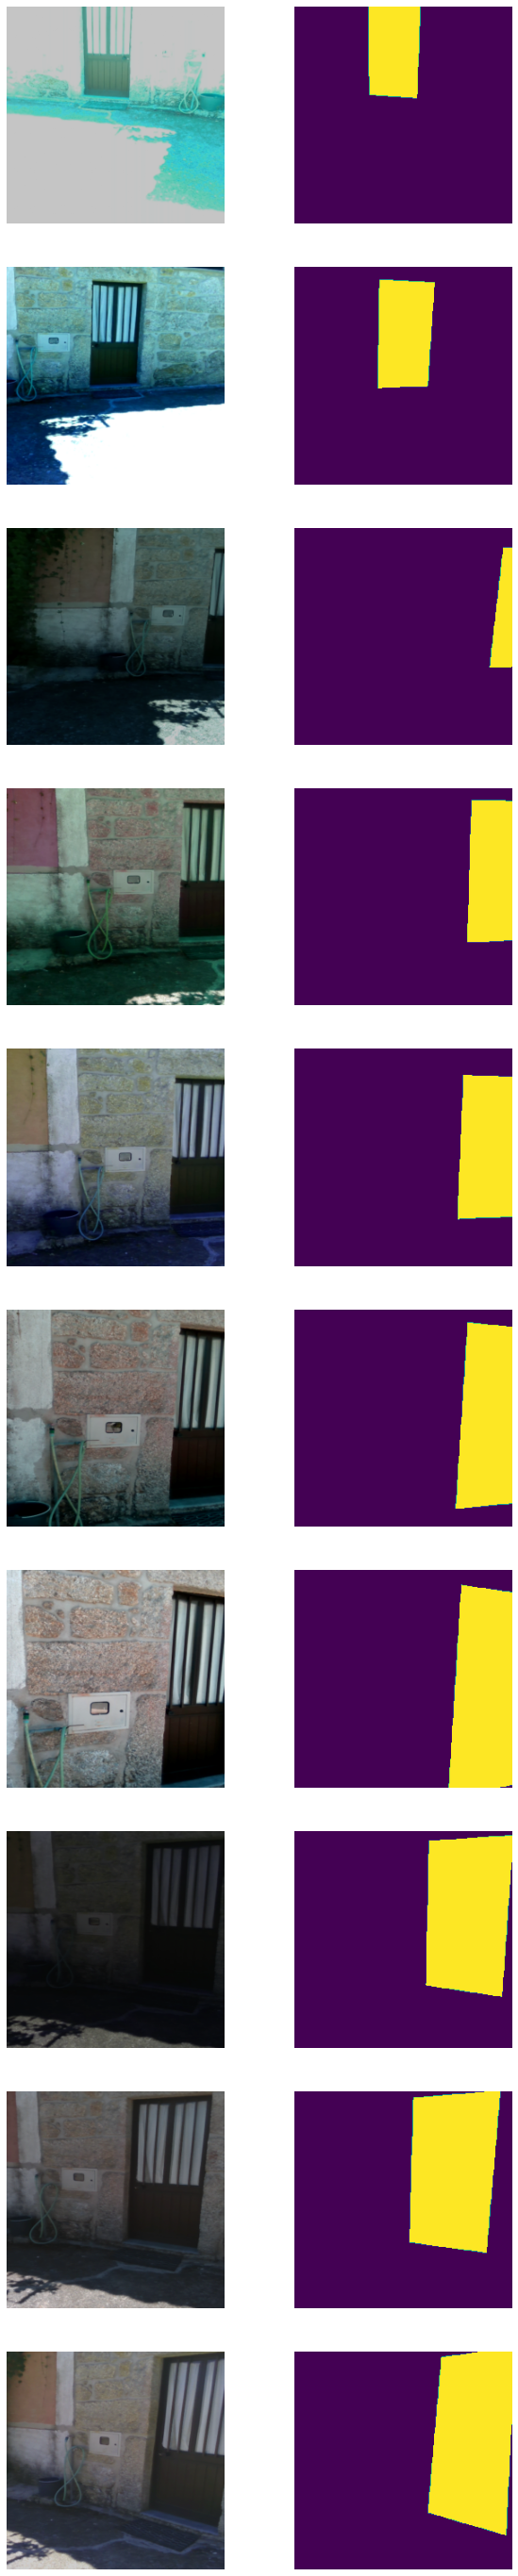

In [ ]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

from datasets.nyuv2 import NYUv2Dataset
from datasets.ade20k import ADE20KDataset
from datasets.deepdoors2 import DD2Dataset

def colormap(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap

def build_dataloaders(dataset,
                      in_domain,
                      out_domain,
                      input_size,
                      batch_size,
                      augment,
                      valid_size=0.2,
                      shuffle=True,
                      show_sample=False,
                      num_workers=4,
                      pin_memory=False):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    if dataset in ['ade20k', 'ade_nyu', 'dd2']:
      
      ade20k_train = ADE20KDataset(
          root_dir="../ADE20K", mode='train', split=valid_size, augment=augment, input_size=input_size, in_domain=in_domain, out_domain=out_domain
      )

      ade20k_val = ADE20KDataset(
          root_dir="../ADE20K", mode='val', split=valid_size, augment=None, input_size=input_size, in_domain=in_domain, out_domain=out_domain
      )

    if dataset in ['nyuv2', 'ade_nyu', 'dd2']:

      nyuv2_train = NYUv2Dataset(
          root_dir="../NYUv2", mode='train', split=valid_size, augment=augment, input_size=input_size, in_domain=in_domain, out_domain=out_domain
      )

      nyuv2_val = NYUv2Dataset(
          root_dir="../NYUv2", mode='val', split=valid_size, augment=None, input_size=input_size, in_domain=in_domain, out_domain=out_domain
      )

      dd2_train = DD2Dataset(
          root_dir="../DeepDoors2", mode='train', split=0, augment=augment, input_size=input_size, in_domain=in_domain, out_domain=out_domain
      )
      

    if dataset == 'ade20k':

      train = ade20k_train
      val = ade20k_val
    
    elif dataset == 'nyuv2':

      train = nyuv2_train
      val = nyuv2_val

    elif dataset == 'ade_nyu':

      train = ConcatDataset([ade20k_train, nyuv2_train])
      val = ConcatDataset([ade20k_val, nyuv2_val])

    elif dataset == 'dd2':

      train = dd2_train
      val = ConcatDataset([ade20k_val, nyuv2_val])

    
    num_train = len(train)
    num_val = len(val)
    # indices = list(range(num_train))
    # split = int(np.floor(valid_size * num_train))

    print("Train dataset size: {}".format(num_train))
    print("Validation dataset size: {}".format(num_val))

    # if shuffle:
    #     np.random.shuffle(indices)

    # train_idx, valid_idx = indices[split:], indices[:split]
    # train_sampler = SubsetRandomSampler(train_idx)
    # valid_sampler = SubsetRandomSampler(valid_idx)

    if show_sample:
      
      print("10 random samples:")

      cmap = colormap()
      
      inds = range(10)
      fig, axs = plt.subplots(10, 2)
      fig.set_figheight(50)
      fig.set_figwidth(10)

      for i, ind in enumerate(inds):
        x, y = train[ind]

        x = np.transpose(x, (1, 2, 0))

        axs[i, 0].imshow(x)
        axs[i, 0].axis('off')

        # x = np.squeeze(x, axis=0)
        # x = cmap[x.astype(np.uint8)]

        axs[i, 1].imshow(y)
        axs[i, 1].axis('off')

      plt.show()

    train_loader = DataLoader(
        train, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = DataLoader(
        val, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader, valid_loader)


trainLoader, valLoader = build_dataloaders(dataset='dd2',
                                               in_domain='rgb',
                                               out_domain='seg',
                                               input_size=(256, 256),
                                               batch_size=16,
                                               augment=True,
                                               valid_size=0.2,
                                               shuffle=True,
                                               show_sample=True,
                                               num_workers=2,
                                               pin_memory=True)